In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import os
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# folder_path="/content/drive/MyDrive/current/ML-project/dataTop/5_image/"
# folder_path="/content/drive/MyDrive/ML-project/dataTop5_image/"
folder_path='/content/drive/MyDrive/current/ML-project/dataTop5_image/'
na_class=os.listdir(folder_path)
print(na_class)

['comrav', 'houspa', 'houwre', 'redcro', 'sonspa']


In [4]:
X=[]
Y=[]
# image_size=226
i=0
for cl in na_class:
  clpath=folder_path+cl
  names=os.listdir(clpath)
  for n in names:
    rpath=clpath+"/"+n
    # img=cv2.imread(rpath,0)
    # img=cv2.resize(img, (image_size, image_size))
    # X.append(img)
    X.append(rpath)
    Y.append(i)
  i+=1
X=np.asarray(X)
Y=np.asarray(Y)

In [5]:
print(len(Y))

3830


In [8]:
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=12)

x_train, X_temp, y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=12)
x_val, x_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=12)

print(len(x_train), len(x_val), len(x_test))

3064 383 383


In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(224, padding=4),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [10]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

class cDataset(Dataset):
    def __init__(self, root, labels, transform=None):
      self.root = root
      self.labels = labels
      self.transform = transform
    
    def __len__(self):
      return len(self.labels)
        
    def __getitem__(self, index):
      path = self.root[index]
      label = self.labels[index]
      with open(path, 'rb') as f:
        sample = Image.open(f).convert('RGB')
        # sample = Image.open(f).convert('L')
      if self.transform is not None:
        sample = self.transform(sample)
      return sample, label

In [11]:
print(x_train[0])

/content/drive/MyDrive/current/ML-project/dataTop5_image/redcro/XC137972.png


In [20]:
bs=256
trainset = cDataset(x_train, y_train, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True,drop_last = True)

valset = cDataset(x_test, y_test, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=bs)

testset = cDataset(x_test, y_test, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs)


In [21]:
print(len(trainset))
n_total_steps = len(trainloader)
print(n_total_steps)

3064
11


In [14]:
for b_idx, (inputs, targets) in enumerate(trainloader):
  print(b_idx)
  # print(inputs)
  print(targets)
  break

0
tensor([1, 1, 1, 4, 4, 3, 4, 3, 0, 0, 2, 2, 3, 3, 3, 2])


In [15]:
torch.cuda.is_available() 

True

In [16]:
# https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# model = models.resnet34(pretrained=True)
# 18
# try with efficientNetB3 (trained on imagenet)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
from torch import nn
from torch import optim
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 5),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
epochs = 1
steps = 0
running_loss = 0
# print_every = 10
# print_every = 20
print_every = 5
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Step {steps} Epoch {epoch+1}/{epochs}.. ")
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(valloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(valloader):.3f}")
            running_loss = 0
            model.train()
            torch.save(model, 'aerialmodel0.pth')
torch.save(model, 'aerialmodel.pth')

Step 1 Epoch 1/1.. 
Step 2 Epoch 1/1.. 
Step 3 Epoch 1/1.. 
Step 4 Epoch 1/1.. 
Step 5 Epoch 1/1.. 
Epoch 1/1.. Train loss: 1.601.. Test loss: 1.482.. Test accuracy: 0.390
Step 6 Epoch 1/1.. 
Step 7 Epoch 1/1.. 
Step 8 Epoch 1/1.. 
Step 9 Epoch 1/1.. 
Step 10 Epoch 1/1.. 
Epoch 1/1.. Train loss: 1.472.. Test loss: 1.498.. Test accuracy: 0.376
Step 11 Epoch 1/1.. 


In [23]:
import pickle
f=open("resnet50.pkl", "wb")
# f=open("/content/drive/MyDrive/current/ML A2/vgg16-finetuned.pkl","wb")
pickle.dump(model,f)  # saving weights
f.close()

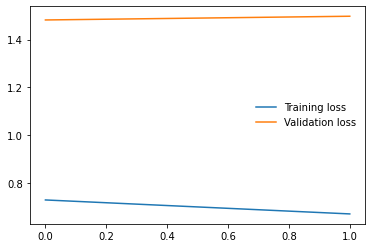

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [25]:
epochs = 10
steps = 0
running_loss = 0
# print_every = 10
print_every = 5
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Step {steps} Epoch {epoch+1}/{epochs}.. ")
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(valloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(valloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Step 1 Epoch 1/10.. 
Step 2 Epoch 1/10.. 
Step 3 Epoch 1/10.. 
Step 4 Epoch 1/10.. 
Step 5 Epoch 1/10.. 
Epoch 1/10.. Train loss: 1.380.. Test loss: 1.330.. Test accuracy: 0.500
Step 6 Epoch 1/10.. 
Step 7 Epoch 1/10.. 
Step 8 Epoch 1/10.. 
Step 9 Epoch 1/10.. 
Step 10 Epoch 1/10.. 
Epoch 1/10.. Train loss: 1.294.. Test loss: 1.287.. Test accuracy: 0.469
Step 11 Epoch 1/10.. 
Step 12 Epoch 2/10.. 
Step 13 Epoch 2/10.. 
Step 14 Epoch 2/10.. 
Step 15 Epoch 2/10.. 
Epoch 2/10.. Train loss: 1.229.. Test loss: 1.247.. Test accuracy: 0.471
Step 16 Epoch 2/10.. 
Step 17 Epoch 2/10.. 
Step 18 Epoch 2/10.. 
Step 19 Epoch 2/10.. 
Step 20 Epoch 2/10.. 
Epoch 2/10.. Train loss: 1.208.. Test loss: 1.217.. Test accuracy: 0.539
Step 21 Epoch 2/10.. 
Step 22 Epoch 2/10.. 
Step 23 Epoch 3/10.. 
Step 24 Epoch 3/10.. 
Step 25 Epoch 3/10.. 
Epoch 3/10.. Train loss: 1.158.. Test loss: 1.150.. Test accuracy: 0.549
Step 26 Epoch 3/10.. 
Step 27 Epoch 3/10.. 
Step 28 Epoch 3/10.. 
Step 29 Epoch 3/10.. 
Step 3

In [26]:
import pickle
f=open("resnet50_0.pkl", "wb")
# f=open("/content/drive/MyDrive/current/ML A2/vgg16-finetuned.pkl","wb")
pickle.dump(model,f)  # saving weights
f.close()

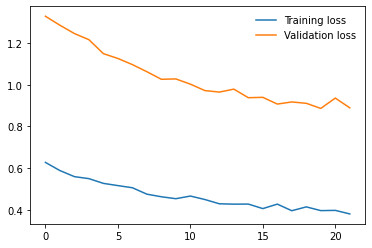

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

Evaluation

In [28]:
n_c=5 # number of classes is 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cm=torch.zeros(n_c, n_c)  # creating confusion matrix
model.eval()  # setting model for evaluation
nsamples,ncorrect=0,0
for i,(inputs,labels) in enumerate(testloader):  # using the test data
  inputs=inputs.to(device)
  labels=labels.to(device)
  outputs=model(inputs)  # getting the outputs
  _, pred=torch.max(outputs, 1)
  nsamples+=labels.size(0)
  ncorrect+=(pred==labels).sum().item()  # getting the correct number of sampels
  for l, p in zip(labels,pred):
    cm[l.long(), p.long()] += 1  # adding values to confusion matrix

print("Accuracy on test data=",100*ncorrect/nsamples)
print("Confusion matrix on test data:")
print(cm)

Accuracy on test data= 65.53524804177546
Confusion matrix on test data:
tensor([[51.,  1.,  3.,  7.,  2.],
        [ 6., 45.,  5.,  6.,  6.],
        [ 7.,  6., 34., 10., 14.],
        [14., 10.,  6., 99., 13.],
        [ 3.,  2.,  5.,  6., 22.]])


In [ ]:
# https://medium.datadriveninvestor.com/creating-a-pytorch-image-classifier-da9db139ba80

In [29]:
epochs = 10
steps = 0
running_loss = 0
# print_every = 10
print_every = 5
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Step {steps} Epoch {epoch+1}/{epochs}.. ")
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(valloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(valloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

import pickle
f=open("resnet50_0.pkl", "wb")
# f=open("/content/drive/MyDrive/current/ML A2/vgg16-finetuned.pkl","wb")
pickle.dump(model,f)  # saving weights
f.close()

Step 1 Epoch 1/10.. 
Step 2 Epoch 1/10.. 
Step 3 Epoch 1/10.. 
Step 4 Epoch 1/10.. 
Step 5 Epoch 1/10.. 
Epoch 1/10.. Train loss: 0.811.. Test loss: 0.880.. Test accuracy: 0.659
Step 6 Epoch 1/10.. 
Step 7 Epoch 1/10.. 
Step 8 Epoch 1/10.. 
Step 9 Epoch 1/10.. 
Step 10 Epoch 1/10.. 
Epoch 1/10.. Train loss: 0.822.. Test loss: 0.961.. Test accuracy: 0.626
Step 11 Epoch 1/10.. 
Step 12 Epoch 2/10.. 
Step 13 Epoch 2/10.. 
Step 14 Epoch 2/10.. 
Step 15 Epoch 2/10.. 
Epoch 2/10.. Train loss: 0.859.. Test loss: 0.881.. Test accuracy: 0.661
Step 16 Epoch 2/10.. 
Step 17 Epoch 2/10.. 
Step 18 Epoch 2/10.. 
Step 19 Epoch 2/10.. 
Step 20 Epoch 2/10.. 
Epoch 2/10.. Train loss: 0.860.. Test loss: 0.916.. Test accuracy: 0.632
Step 21 Epoch 2/10.. 
Step 22 Epoch 2/10.. 
Step 23 Epoch 3/10.. 
Step 24 Epoch 3/10.. 
Step 25 Epoch 3/10.. 
Epoch 3/10.. Train loss: 0.835.. Test loss: 0.896.. Test accuracy: 0.649
Step 26 Epoch 3/10.. 
Step 27 Epoch 3/10.. 
Step 28 Epoch 3/10.. 
Step 29 Epoch 3/10.. 
Step 3

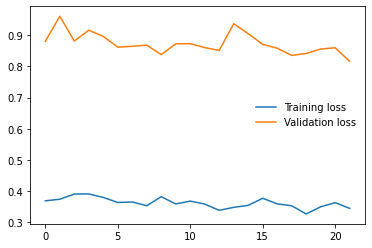

In [30]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [31]:
n_c=5 # number of classes is 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cm=torch.zeros(n_c, n_c)  # creating confusion matrix
model.eval()  # setting model for evaluation
nsamples,ncorrect=0,0
for i,(inputs,labels) in enumerate(testloader):  # using the test data
  inputs=inputs.to(device)
  labels=labels.to(device)
  outputs=model(inputs)  # getting the outputs
  _, pred=torch.max(outputs, 1)
  nsamples+=labels.size(0)
  ncorrect+=(pred==labels).sum().item()  # getting the correct number of sampels
  for l, p in zip(labels,pred):
    cm[l.long(), p.long()] += 1  # adding values to confusion matrix

print("Accuracy on test data=",100*ncorrect/nsamples)
print("Confusion matrix on test data:")
print(cm)

Accuracy on test data= 66.0574412532637
Confusion matrix on test data:
tensor([[ 51.,   2.,   3.,   6.,   2.],
        [  5.,  48.,   7.,   7.,   1.],
        [  9.,   7.,  36.,  14.,   5.],
        [ 12.,  11.,   8., 104.,   7.],
        [  6.,   2.,   9.,   7.,  14.]])
